<a href="https://colab.research.google.com/github/Stelath/geoguessr-ai/blob/main/GeoGuessr_AI_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoGuessr-AI Demo

Disclaimer, this model was only trained on pictures from 5 cities (Washington, City of New York, Chicago, Detroit, and San Francisco) and will therefore only be able to predict the location of photos taken in those cities.

## Setup

In [ ]:
!gdown 'https://drive.google.com/uc?id=1VJpeLJp6jC8IUfKy6cAtZ9WZcX1TTutW&confirm=t'

Downloading...
From: https://drive.google.com/uc?id=1VJpeLJp6jC8IUfKy6cAtZ9WZcX1TTutW&confirm=t
To: /content/geoguessr_production_model.pt
100% 269M/269M [00:01<00:00, 199MB/s]


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np
from PIL import Image
import os

from google.colab import files

model = models.wide_resnet50_2(pretrained=False, progress=True, num_classes=142)
model = nn.Sequential(
    model,
    nn.Sigmoid()
)
model_file = torch.load('geoguessr_production_model.pt', map_location=torch.device('cpu'))
model.load_state_dict(model_file)
model.eval()
print('Loaded Model')

def reformat(arr, guess_num=1):
  num = ''
  if arr[0] >= 0.5:
    num += '-'
  
  arr = arr[1:]

  for idx in range(0, len(arr), 10):
    if idx == 30:
      num += '.'
    num += str(np.where(arr[idx:idx+10] == np.partition(arr[idx:idx+10].flatten(), -guess_num)[-guess_num])[0][0] % 10)

  return num

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize,
    ])

Loaded Model


## Run Model

Saving sample_image.jpeg to sample_image.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


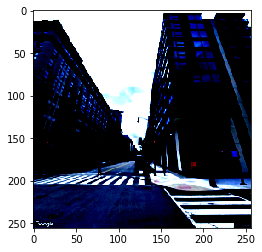

In [ ]:
#@title ## Load File

reference_file = files.upload()
reference_file = list(reference_file.keys())[0]

img_path = os.path.join(reference_file)
img = Image.open(img_path)
data = transform(img)

from matplotlib import pyplot as plt
img = data.permute(1, 2, 0)
plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
#@title ## Make Prediction
#@markdown Run the model and get a lattitude and longitude prediction based on the image, the model will predict the most likely location and then make a backup guess as well.

with torch.no_grad():
  data = data.view(-1,3,256,256)
  output = model(data)

target_split_len = int(len(output.cpu().numpy()[0])/2)
output_reformatted = reformat(output.cpu().numpy()[0][:target_split_len]) + ' ' + reformat(output.cpu().numpy()[0][target_split_len:])
output_reformatted2 = reformat(output.cpu().numpy()[0][:target_split_len]) + ' ' + reformat(output.cpu().numpy()[0][target_split_len:], 2)
print('First Guess:', output_reformatted)
print('Second Guess:', output_reformatted2)

First Guess: 037.7838 -122.4105
Second Guess: 037.7838 -073.3263
